# CNN Classification of Mel Spectrograms

Tried and follow
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

In [ ]:
# For Colab only
from google.colab import drive
drive.mount('content/') # /content/drive/MyDrive/bird-songs

Mounted at content/


## Training a model

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob

# for reading and displaying images
from skimage.io import imread
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data.dataloader import DataLoader, Dataset


In [60]:
# Check whether google drive mounted
path = '/content/content/MyDrive/bird-songs'
if os.path.isdir(path) == True:
    run_on_colab = True
else:
    run_on_colab = False



if run_on_colab ==True:
    features = pd.read_csv('/content/content/MyDrive/bird-songs/features_filtered.csv', header=None, encoding='latin')
else:
    features = pd.read_csv('features_filtered.csv', encoding='latin')
features.set_index('id', inplace=True)
features.head()

,gen,sp,ssp,en,cnt,loc,type,q,length,bird-seen,file,category
id,,,,,,,,,,,,
564895,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lyons Township (near Willow Springs), Cook Co...","adult, sex uncertain, song",no score,0:16,no,//www.xeno-canto.org/564895/download,song
545775,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Valley Forge National Historical Park, Montgom...",call,no score,0:17,yes,//www.xeno-canto.org/545775/download,call
540857,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:32,unknown,//www.xeno-canto.org/540857/download,song
540855,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Slaterville Rd @ Honness (near Ithaca), Tompk...",song,no score,0:52,unknown,//www.xeno-canto.org/540855/download,song
487506,Thryothorus,ludovicianus,NaN,Carolina Wren,United States,"Lake Artemesia Natural Area, Prince George's C...",song,no score,0:25,yes,//www.xeno-canto.org/487506/download,song


In [88]:
audio_files = []
for file in glob.glob("audio_augmentation/*"):
    audio_files.append(file.split('-')[-1].split('.')[0])
audio_files

['100144001',
 '100144002',
 '100144003',
 '100144004',
 '100251001',
 '100580001',
 '100580002',
 '100650001',
 '100650002',
 '100650003',
 '100650004',
 '101261001',
 '101261002',
 '101306001',
 '101437001',
 '101437002',
 '101437003',
 '101437004',
 '101437005',
 '101611001',
 '10169001',
 '10169002',
 '10169003',
 '10169004',
 '10169005',
 '10169006',
 '10169007',
 '10169008',
 '10169009',
 '10169010',
 '10169011',
 '10169012',
 '10169013',
 '10169014',
 '10169015',
 '10169016',
 '10169017',
 '10169018',
 '10169019',
 '10169020',
 '10169021',
 '10170001',
 '10170002',
 '10170003',
 '10170004',
 '10170005',
 '10170006',
 '10170007',
 '10170008',
 '10170009',
 '101831001',
 '101831002',
 '101896001',
 '101896002',
 '102206001',
 '102206002',
 '102206003',
 '102206004',
 '102206005',
 '102206006',
 '102206007',
 '102206008',
 '102206009',
 '102206010',
 '102206011',
 '102944001',
 '102944002',
 '103205001',
 '103205002',
 '103205003',
 '103205004',
 '103205005',
 '103205006',
 '103205

In [89]:
augmented_features = pd.DataFrame(audio_files).rename(columns={0:'id'})
augmented_features['bird'] = augmented_features.apply(lambda row: features.loc[int(row['id'][:-3])]['en'], axis=1)
augmented_features['category'] = augmented_features.apply(lambda row: features.loc[int(row['id'][:-3])]['category'], axis=1)
augmented_features

,id,bird,category
0,100144001,Common Yellowthroat,song
1,100144002,Common Yellowthroat,song
2,100144003,Common Yellowthroat,song
3,100144004,Common Yellowthroat,song
4,100251001,Spotted Towhee,song
...,...,...,...
14581,97949003,Northern Cardinal,song
14582,97949004,Northern Cardinal,song
14583,97949005,Northern Cardinal,song
14584,97949006,Northern Cardinal,song


In [163]:
songs.loc[:7]

,id,label
0,100144001,1
1,100144002,1
2,100144003,1
3,100144004,1
4,100251001,5
5,100580001,2
6,100580002,2


In [90]:
# These are the top species we selected for our analysis
selected_species = ['Red-winged Blackbird', 
                    'Common Yellowthroat', 
                    'Northern Cardinal', 
                    'Carolina Wren', 
                    'Red Crossbill', 
                    'Spotted Towhee']
# We only need the id and the labels for our CNN.
dataset = augmented_features
# Now we need to change our labels into integers as torch does not support string format for labels.
labels = {"Red-winged Blackbird": 0, 'Common Yellowthroat': 1, 'Northern Cardinal': 2, 'Carolina Wren': 3,
          'Red Crossbill': 4, 'Spotted Towhee': 5}
dataset['label'] = dataset.apply(lambda row: labels[row.bird], axis=1)

In [91]:
songs = dataset[dataset.category == 'song'].drop(['bird', 'category'], axis=1)
calls = dataset[dataset.category == 'call'].drop(['bird', 'category'], axis=1)
len(songs), len(calls)

(10053, 4533)

# CNN Baseline

In [174]:
def load_images(dataset):
    img_df = []
    errors = []
    for img_name in tqdm(dataset['id']):
        # defining the image path
        if run_on_colab == True:
            image_path = f'/content/content/MyDrive/bird-songs/images/mel_spectrograms_augmented_data/resampled-clean-' + str(img_name) + '.jpg' 
        else:
            image_path = f'images/mel_spectrograms_augmented_data/resampled-clean-' + str(img_name) + '.jpg'
        # reading the image
        img = imread(image_path, as_gray=True)
         # normalizing the pixel values
        img = 2 * img - 1
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        if img.shape != (128, 89):
            errors.append(img_name)
        else:
            img_df.append(list(img))
    
    # converting the list to numpy array
    return np.array(img_df), errors

def plot_accuracies(history):

    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-o', label='training accuracy')
    plt.plot(val_accuracies, '-x', label='validation accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend();
    
def plot_loss(history):

    train_accuracies = [x['train_loss'] for x in history]
    val_accuracies = [x['val_loss'] for x in history]
    plt.figure(figsize=(12, 8))
    plt.plot(train_accuracies, '-o', label='training loss')
    plt.plot(val_accuracies, '-x', label='validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.legend();

In [119]:
class ImageClassifierBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)         # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [200]:
class BirdSongModel(ImageClassifierBase):
    def __init__(self):
        super().__init__()
        
        conv_layers = []

        self.conv1 = nn.Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.GroupNorm(2, 16)
        nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.pool1 = nn.MaxPool2d(2)
        conv_layers += [self.conv1, self.relu1, self.bn1, self.pool1]

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(0, 0))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.GroupNorm(4, 32)
        nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.pool2 = nn.MaxPool2d(2)
        conv_layers += [self.conv2, self.relu2, self.bn2, self.pool2]
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.relu3 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.pool3 = nn.MaxPool2d(2)
        conv_layers += [self.conv3, self.relu3, self.pool3]

        self.conv4 = nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0))
        self.relu4 = nn.ReLU()
        nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.pool4 = nn.MaxPool2d(2)
        conv_layers += [self.conv4, self.relu4, self.pool4]
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128*7*5, 50)
        self.relufc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.linear2 = nn.Linear(50, 10)
        self.relufc2 = nn.ReLU()
        self.linear3 = nn.Linear(10, 6)
        conv_layers += [self.flatten, self.linear1, self.relufc1, self.dropout,
                        self.linear2, self.relufc2, self.linear3]
        
        self.network = nn.Sequential(*conv_layers)
        print(conv_layers)

    def forward(self, x):
        return self.network(x)


If you have compatible GPU technology on your computer, you can run the CNN on it instead of CPU. 
If you are using anaconda, either create a new environment or uninstall pytorch in your current environment (if already installed) then install PyTorch with cuda:

`conda install pytorch torchvision cudatoolkit=10.2 -c pytorch`

Running this CNN on CPU takes about 17 minutes on a Dell XPS 15 9500 with 1TB SSD and 32GB RAM (2x16GB) with Windows 10. Switching to using the NVIDIA GeForce GTX 1650 it takes less than 5minutes. 

In [201]:
# Helper functions to have option of running with GPU or CPU
def get_default_device():
    """Create device: Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) of data to chosen device"""
    # If list of tensors
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # else if single tensor
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to yield data to device as
    the batches are requested"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [202]:
# Helper functions to fit and evaluate model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracies = []
        for batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            # Calculate loss
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accuracies.append(acc)
            # Back-propogate loss
            loss.backward()
            # Update weights
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# CNN on Songs Dataset

In [180]:
X, err_idx = load_images(songs)
y = songs[~songs.id.isin(err_idx)]['label'].values
X.shape, y.shape

100%|███████████████████████████████████████████████████████████████████████████| 10053/10053 [01:06<00:00, 151.53it/s]


((10017, 128, 89), (10017,))

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(X_test.shape)


(7011, 128, 89)
(3006, 128, 89)


In [204]:
train_data = []
# Note: Conv2d layers expect input with the shape (n_samples, channels, height, width)
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) 
test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])

In [205]:
batch_size=100
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [199]:
# Test image size
simple_model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=1, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(2),

#     nn.Flatten(), 
#     nn.Linear(256*3*7, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, 5)
)
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([100, 1, 128, 89])
out.shape: torch.Size([100, 128, 7, 5])


In [206]:
device = get_default_device()
# print(device)
model = to_device(BirdSongModel(), device)

# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# evaluate(model, test_dl)

num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00004

[Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1)), ReLU(), GroupNorm(2, 16, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)), ReLU(), GroupNorm(4, 32, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=4480, out_features=50, bias=True), ReLU(), Dropout(p=0.5, inplace=False), Linear(in_features=50, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=6, bias=True)]


In [23]:
# for layer in model.children():
#     if hasattr(layer, 'reset_parameters'):
#         print(f'Reset trainable parameters of layer = {layer}')
#         layer.reset_parameters()

In [207]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.6545, train_acc: 0.3266, val_loss: 1.5653, val_acc: 0.3397
Epoch [1], train_loss: 1.5519, train_acc: 0.3651, val_loss: 1.4682, val_acc: 0.4243
Epoch [2], train_loss: 1.4605, train_acc: 0.4259, val_loss: 1.3717, val_acc: 0.4863
Epoch [3], train_loss: 1.3936, train_acc: 0.4627, val_loss: 1.3037, val_acc: 0.5277
Epoch [4], train_loss: 1.3388, train_acc: 0.4934, val_loss: 1.2458, val_acc: 0.5547
Epoch [5], train_loss: 1.2825, train_acc: 0.5256, val_loss: 1.2124, val_acc: 0.5817
Epoch [6], train_loss: 1.2468, train_acc: 0.5433, val_loss: 1.1757, val_acc: 0.5797
Epoch [7], train_loss: 1.2038, train_acc: 0.5647, val_loss: 1.1220, val_acc: 0.6170
Epoch [8], train_loss: 1.1539, train_acc: 0.5834, val_loss: 1.0907, val_acc: 0.6090
Epoch [9], train_loss: 1.1494, train_acc: 0.5860, val_loss: 1.0762, val_acc: 0.6190
Epoch [10], train_loss: 1.1066, train_acc: 0.6087, val_loss: 1.0421, val_acc: 0.6297
Epoch [11], train_loss: 1.0854, train_acc: 0.6097, val_loss: 1.0262, val_ac

Epoch [97], train_loss: 0.4056, train_acc: 0.8680, val_loss: 0.7216, val_acc: 0.7617
Epoch [98], train_loss: 0.4102, train_acc: 0.8617, val_loss: 0.7141, val_acc: 0.7630
Epoch [99], train_loss: 0.4039, train_acc: 0.8671, val_loss: 0.7158, val_acc: 0.7633


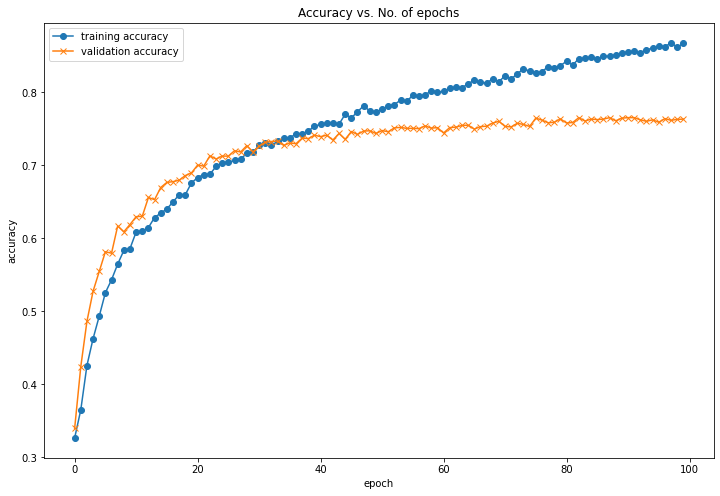

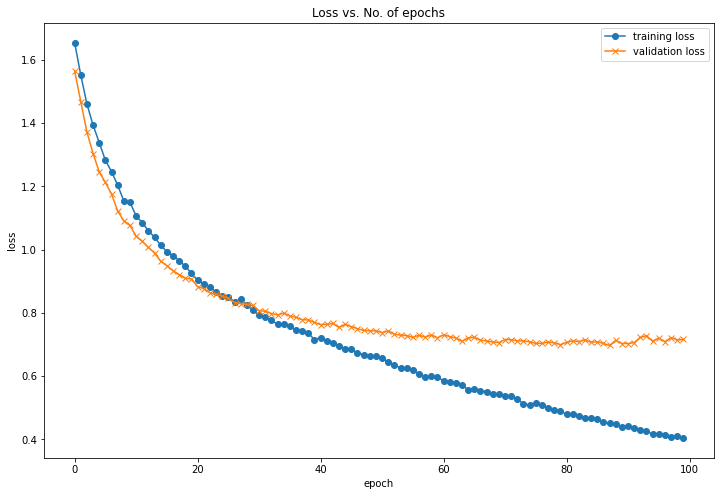

In [208]:
plot_accuracies(history)
plot_loss(history)

In [ ]:
# torch.save(model.state_dict(), "filename.pth")
# print("mdoel training and stored at filename.pth")

# CNN on Calls Dataset

In [209]:
X, err_idx = load_images(calls)
y = calls[~calls.id.isin(err_idx)]['label'].values
X.shape, y.shape

100%|█████████████████████████████████████████████████████████████████████████████| 4533/4533 [00:05<00:00, 768.18it/s]


((4501, 128, 89), (4501,))

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(X_test.shape)

(3150, 128, 89)
(1351, 128, 89)


In [211]:
train_data = []
# Note: Conv2d layers expect input with the shape (n_samples, channels, height, width)
for i in range(len(X_train)):
    train_data.append([np.expand_dims(X_train[i], axis=0), y_train[i]]) 
test_data = []
for i in range(len(X_test)):
    test_data.append([np.expand_dims(X_test[i], axis=0), y_test[i]])
    
batch_size=50
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [212]:
device = get_default_device()
# print(device)
model = to_device(BirdSongModel(), device)

# Wrap training and test data loaders using `DeviceDataLoader` for automatically
# transferring batches of data to the GPU (if available), and use `to_device` 
# to move our model to the GPU (if available).
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

# evaluate(model, test_dl)

num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.00005

[Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1)), ReLU(), GroupNorm(2, 16, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1)), ReLU(), GroupNorm(4, 32, eps=1e-05, affine=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Flatten(start_dim=1, end_dim=-1), Linear(in_features=4480, out_features=50, bias=True), ReLU(), Dropout(p=0.5, inplace=False), Linear(in_features=50, out_features=10, bias=True), ReLU(), Linear(in_features=10, out_features=6, bias=True)]


In [213]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 1.7694, train_acc: 0.1905, val_loss: 1.7139, val_acc: 0.2178
Epoch [1], train_loss: 1.7279, train_acc: 0.2225, val_loss: 1.6785, val_acc: 0.2770
Epoch [2], train_loss: 1.7078, train_acc: 0.2486, val_loss: 1.6509, val_acc: 0.2822
Epoch [3], train_loss: 1.6910, train_acc: 0.2537, val_loss: 1.6310, val_acc: 0.3200
Epoch [4], train_loss: 1.6587, train_acc: 0.2854, val_loss: 1.6135, val_acc: 0.3741
Epoch [5], train_loss: 1.6384, train_acc: 0.3317, val_loss: 1.5818, val_acc: 0.3770
Epoch [6], train_loss: 1.6221, train_acc: 0.3162, val_loss: 1.5687, val_acc: 0.3978
Epoch [7], train_loss: 1.6152, train_acc: 0.3279, val_loss: 1.5632, val_acc: 0.4059
Epoch [8], train_loss: 1.6008, train_acc: 0.3317, val_loss: 1.5317, val_acc: 0.4074
Epoch [9], train_loss: 1.5886, train_acc: 0.3463, val_loss: 1.5187, val_acc: 0.4133
Epoch [10], train_loss: 1.5499, train_acc: 0.3692, val_loss: 1.4952, val_acc: 0.4489
Epoch [11], train_loss: 1.5389, train_acc: 0.3803, val_loss: 1.4882, val_ac

Epoch [97], train_loss: 0.6866, train_acc: 0.7629, val_loss: 1.0538, val_acc: 0.6474
Epoch [98], train_loss: 0.6757, train_acc: 0.7663, val_loss: 1.0411, val_acc: 0.6541
Epoch [99], train_loss: 0.6832, train_acc: 0.7660, val_loss: 1.0450, val_acc: 0.6444


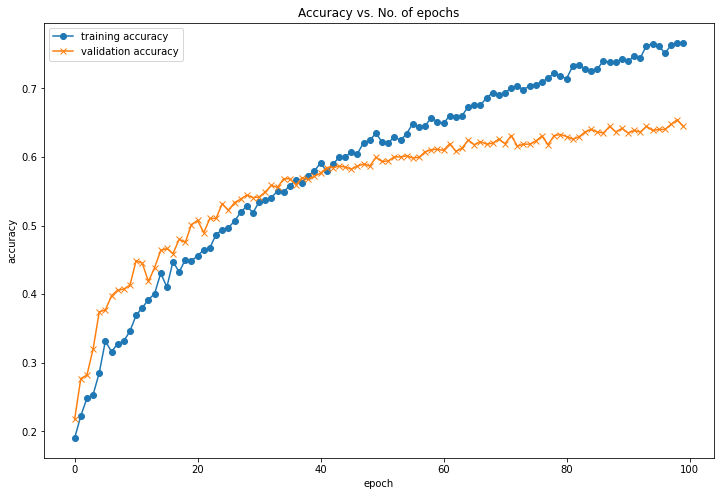

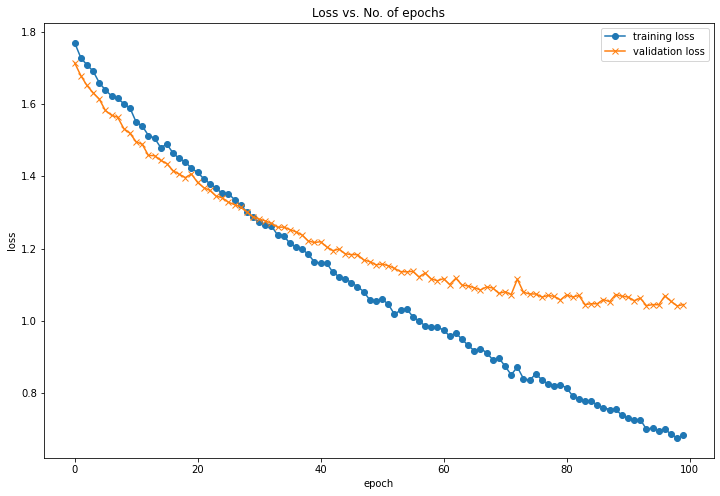

In [214]:
plot_accuracies(history)
plot_loss(history)